# Compare different model outputs against empirical metrics of US MSA income distributions


Descriptive Characteristics of Empirical Distributions, against which to compare models:
- general shape
- decile scaling
- moments vs. population (especially 3rd)
    - NOTE: What about 1st moment? effectively, what about actual scaling behavior across size that won't show up?



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import sklearn.metrics as sk
import scipy.stats
from scipy.optimize import curve_fit
#from RegscorePy import *
from IPython.core.debugger import set_trace
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import lmfit 
#import import_ipynb
#import KEM_Rand

# Input from Data & Model Output
DATA:
Should be saved as pdfs of cities, formatted as 

MODEL OUTPUT:
Should be saved as numpy binary file, formatted as "<model-name>.npy"
The numpy object should be an array with each row representing a city output as a two-element list, with the first element being the population size and the second being an array of the income distribution of that model city.
    Example: 
        "KEM_randnet.npy" = array([[3, array([1, 2, 3])],
                               [5, array([2, 3, 5, 6, 7])]], dtype=object)
        , in which 3 and 5 are population sizes, and the arrays [1,2,3] and [2, 3, 5, 6, 7] are the respective income distributions of
          those cities 

## Input from Model

In [107]:
# CHANGE FILENAMES AND NAMES HERE FOR APPROPRIATE MODEL OUTPUTs
m_incomes = {}
m_pops = {}
m_dat = {}
models = {
    
    # MISC
#     "MEWA (with growing time) on Static BA":"Vicky'sKEM(withgrowingtime)Barbasi-Albert(static)_04-18.npy",
#     "MEWA (with growing time) on Static SW":"Vicky'sKEM(withgrowingtime)small-world(static)_04-18.npy",
#     "MEWA (with growing time) on Densifying SW":"Vicky'sKEM(withgrowingtime)small-world(PortugalPaperparameters)_04-18.npy",
#     "MEWA (with growing time) on Random Net":"Vicky'sKEM(withgrowingtime)RandomNetwork_04-18.npy",
#     "MEWA (with growing time) on Densifying BA":"Vicky'sKEM(withgrowingtime)Barbasi-Albert_04-18.npy",
#     "growth IPDO on Eli's SW":"IPDO_intgrowthsmall-world(Eli'sparameters)_04-18.npy",
#     "Standard IPDO on Eli's SW":"IPDOsmall-world(Eli'sparameters)_04-18.npy",
#     "Vicky's Update Function on Eli's SW":"Vicky'sKEMsmall-world(Eli'sparameters)_04-18.npy",
    
    #RANDOM
#     "IPDO on Portugal Randnet":"IPDORandom(Portugal)_04-18.npy",
#     "Growth IPDO on a Portugal Randnet":"IPDO_intgrowthRandom(Portugal)_04-18.npy",
#     "Vicky's Update Function on Portugal Randnet":"Vicky'sKEMRandom(Portugal)_04-18.npy",
#     "Standard IPDO on Random Network":"IPDORandomNetwork_04-18.npy",
#     "growth IPDO on Random Network":"IPDO_intgrowthRandomNetwork_04-18.npy",
#     "Vicky's Update Function on a random network":"Vicky'sKEMRandomNetwork_04-18.npy",
    
    # Scale-Free (Barbasi-Albert)
#     "IPDO on static BA Net":"IPDOBarbasi-Albert(static)_04-18.npy",
#     "Growth IPDO on a static BA Net":"IPDO_intgrowthBarbasi-Albert(static)_04-18.npy",
#     "Vicky's Update Function on static BA Net":"Vicky'sKEMBarbasi-Albert(static)_04-18.npy",
#     "IPDO on Portugal Barbasi-Albert Network":"IPDOBarbasi-Elbert_04-18.npy",
#     "growth IPDO on Portugal Barbasi-Albert Network":"IPDO_intgrowthBarbasi-Elbert_04-18.npy",
#     "Vicky's Update Function on Portugal Barbasi-Albert Network":"Vicky'sKEMBarbasi-Elbert_04-18.npy",
    
    # SMALL-WORLD
    "IPDO on static SW Net":"IPDOsmall-world(static)_04-18.npy",
    "Growth IPDO on static SW":"IPDO_intgrowthsmall-world(static)_04-18.npy",
    "Vicky's Update Function on static SW net":"Vicky'sKEMsmall-world(static)_04-18.npy",
    "Standard IPDO on portugal SW":"IPDOsmall-world(PortugalPaperparameters)_04-18.npy",
    "growth IPDO on portugal SW":"IPDO_intgrowthsmall-world(PortugalPaperparameters)_04-18.npy",
    "Vicky's Update Function on portugal SW":"Vicky'sKEMsmall-world(PortugalPaperparameters)_04-18.npy"
}
for model in models:
    m_dat[model] = np.load(models[model],allow_pickle=True)
    m_pops[model] = m_dat[model][:,0]
    m_incomes[model] = m_dat[model][:,1]

## Input from Data

In [4]:
data = pd.read_csv("empiricalAnalysis/CTScalingFiles/ct.distr.csv")
idmappings = pd.read_excel("empiricalAnalysis/CTScalingFiles/cbsaidmappings.xls").set_index("CBSA Code")


# maps MSA id to census tract incomes
income_lists = {}
# maps MSA id to census tract population
pops = {}
fullpops = {}
cts = set()
# populations of whole cities (DONE: Cross-check with other data)
city_pops = {}

# If True, will only read in data from MSAs (not Micropolitan SAs). If False, includes all data
ONLY_MSA = True

for _,ct in data.iterrows():
    msa = ct['msa']
    ct_id = ct["ct"]
    
    msa = str(msa)
    metro_micro_lbl = idmappings["Metropolitan/Micropolitan Statistical Area"][msa]
    if not isinstance(metro_micro_lbl,str):
        metro_micro_lbl = list(metro_micro_lbl)[0]
    metro = "Metro" in metro_micro_lbl
    
    # skip over entry if it's a Micro area and you've set the script to only read Metro (not Micro)
    if ONLY_MSA and not metro:
        continue
    
    #NOTE on data: "meandollars is total ct income / # workers... "
    ct_inc = ct["ct.meandollars"]
    pop = ct["ct.totalworkers"]
    fullpop = ct["ct.population"]
    if (ct["ct"],msa) in cts:
        print("WARNING! Found Double census tract id: "+str(ct["ct"]))
        set_trace()
    cts.add((ct["ct"],msa))
    
    if msa not in city_pops:
        city_pops[msa] = ct["pop.sum"]
    
    if msa not in income_lists or msa not in pops:
        income_lists[msa] = []
        pops[msa] = []
        fullpops[msa] = []
    income_lists[msa].append(ct_inc)
    pops[msa].append(pop)
    fullpops[msa].append(fullpop)

In [5]:
e_pops = list(city_pops.values())
e_ctpops = list(fullpops.values())
e_incomes = list(income_lists.values())

## create population list generated from empirical city sizes scaled down to managable sizes

In [26]:

outpop_raw = np.array(sorted(e_pops))
max_model_pop = 7000.
factor = (max_model_pop/np.max(outpop_raw))
print("scaling down by: ",1./factor)
outpop = outpop_raw * factor
# print(outpop)
outpop = list(map(lambda x: round(x,-1), list(outpop)))
# outpop = np.array(list(map(int, list(outpop))))
outpop = np.unique(np.array(outpop))
outpop = outpop[outpop>300]

print(outpop)
np.save("empirical-model_pops.npy",outpop)


msg = "From empiricalAnalysis.ipynb, the scaling fit for the mean income is :\\y0 = 19452.956275401906 \\beta = 0.07603054329370625"
print(msg)

scaling down by:  2902.3745714285715
[ 310.  320.  330.  340.  350.  360.  370.  380.  400.  410.  430.  460.
  470.  480.  490.  520.  570.  600.  620.  670.  710.  720.  750.  760.
  790.  810.  830.  840.  850.  870.  990. 1010. 1020. 1040. 1140. 1260.
 1270. 1530. 1540. 1570. 1610. 1740. 2020. 2040. 2180. 2190. 2230. 2400.
 3350. 4580. 7000.]
From empiricalAnalysis.ipynb, the scaling fit for the mean income is :\y0 = 19452.956275401906 \beta = 0.07603054329370625


# General Shape

## Model

In [ ]:

"""
creates and displays a probability distribution function of the model 
incomes, generated from a Gaussian Kernel Density Estimation
"""

def wide_silverman(kde_inst):
    n = kde_inst.n
    d = kde_inst.d
    silverman = (n * (d + 2) / 4.)**(-1. / (d + 4))
    scale = 2.
    return silverman*scale

incomes = np.array(sim.get_income_dist())
# print(min(incomes))
# incomes *= 300000./np.max(incomes)
kde = scipy.stats.gaussian_kde(sim.get_income_dist(),bw_method=wide_silverman)
x = np.linspace(0,1.2*max(incomes),100)




#ax1 = sns.kdeplot(income_list, bw=1)

datx,daty = x,kde.pdf(x)

plt.figure()
plt.plot(datx,daty,c='red')
ax2 = sns.rugplot(incomes)

plt.title("Pure Random KEM Simulation")
plt.xlabel("income")
plt.ylabel("probability")
plt.show()
plt.close()





## Empirical (NOTE: THIS IS OUTDATED; SEE UPDATED VERSION IN CityDistributions.ipynb) 

In [ ]:
kde_distr = {}
kde_distr_small = {}
kde_pdfs = {}
x_inc_all = []
y_pop_all = []


def wide_silverman(kde_inst):
    n = kde_inst.n
    d = kde_inst.d
    silverman = (n * (d + 2) / 4.)**(-1. / (d + 4))
    scale = 2.
    return silverman*scale



for msa in income_lists:
    income_list = income_lists[msa]
    #set_trace()
    #print(income_list)
    pop = fullpops[msa]
    x = np.linspace(0,1.2*max(income_list),100)
    income_list = np.array(income_list)
    pop = np.array(fullpops[msa])/sum(fullpops[msa])
    
    plt.figure()
    
    kernel = scipy.stats.gaussian_kde(income_list,weights=pop,bw_method=wide_silverman)
    
    
    
    sumprob = scipy.integrate.quad(kernel.pdf,0,1.2*max(income_list))
    
    
    
    
    #ax1 = sns.kdeplot(income_list, bw=1)
    
    datx,daty = x,kernel.pdf(x)
    
    plt.plot(datx,daty,c='red')
    ax2 = sns.rugplot(income_list)
    
    metro = str(msa) in metro_ids
    msaname = idmappings["CBSA Title"][str(msa)]
    if not isinstance(msaname,str):
        msaname = list(msaname)[0]
    if metro:
        msaname += " (Metro Area)"
    else:
        msaname += " (Micro Area)"
        
    plt.title(msaname)
    plt.xlabel("income")
    plt.ylabel("probability")
    
    
#     plt.plot(support,kernel,c='orange')
# #     kde_distr[msa] = (support, kernel)
    n_samples = round(n_cts[msa]**.75/6)
    if n_samples < 15:
        n_samples = 15
    small_sample = np.linspace(0,1.2*max(income_list),n_samples)
    kde_distr[msa] = (datx, daty)
    kde_distr_small[msa] = (small_sample, kernel.pdf(small_sample))
    kde_pdfs[msa] = kernel.pdf
    
    
    
    
    plt.show()
    plt.close()

# Moment distribution

## Model

model: growth IPDO on Barbasi-Albert Network


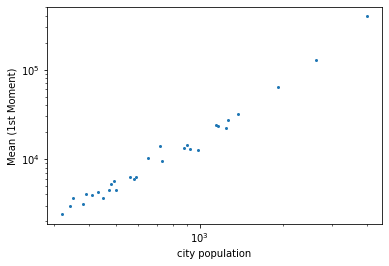

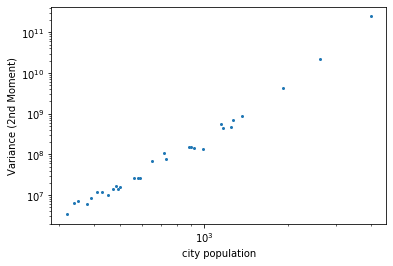

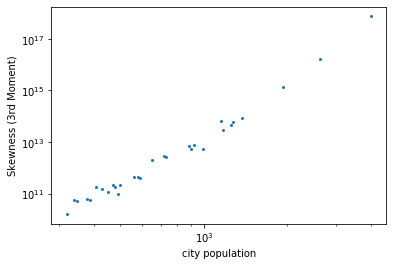

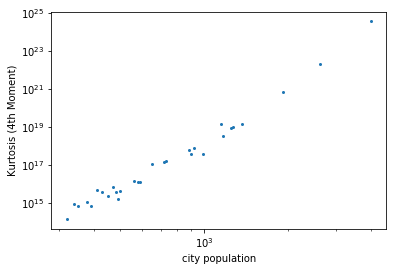

model: Vicky's Update Function on a Barbasi-Albert Network


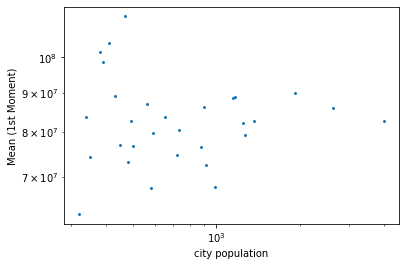

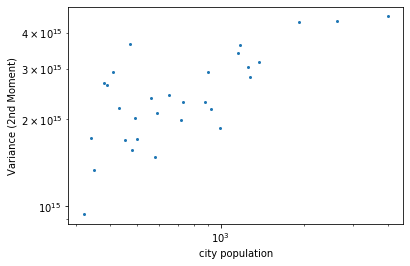

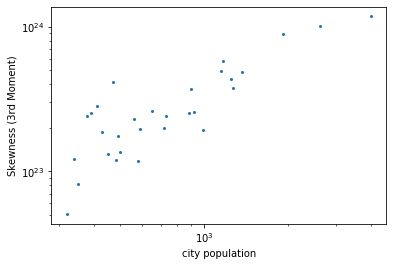

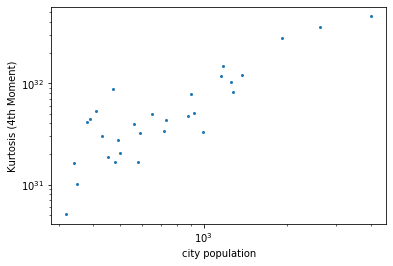

model: Vicky's Update Function on a scale-free Network


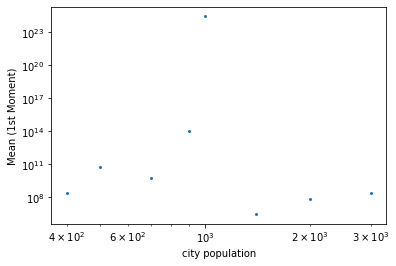

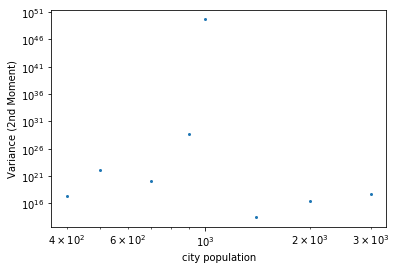

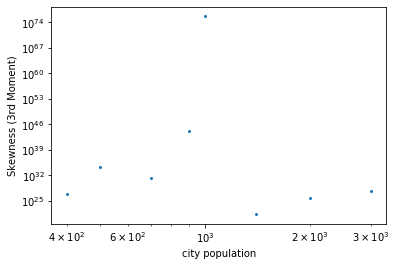

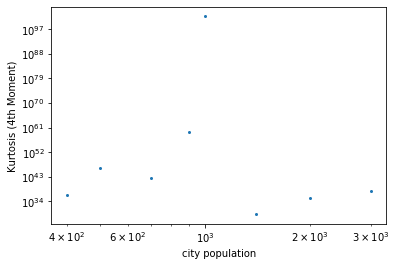

model: IPDO on a Barbasi-Albert Network


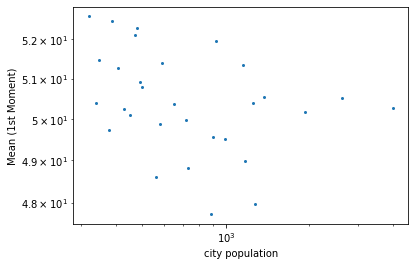

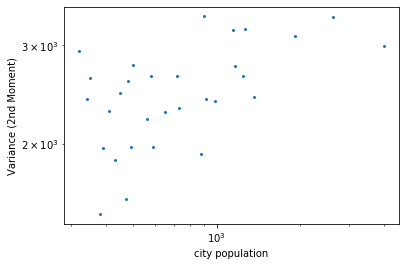

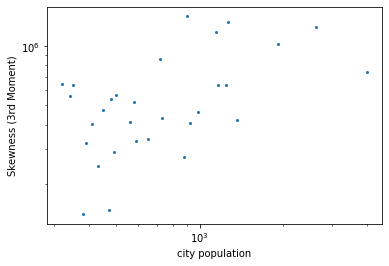

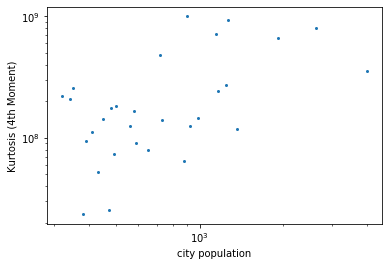

model: Standard IPDO on Random Network


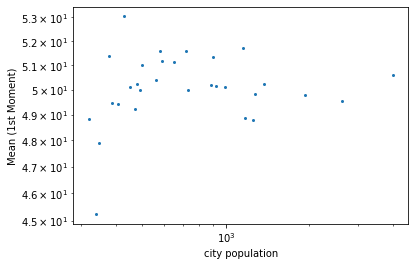

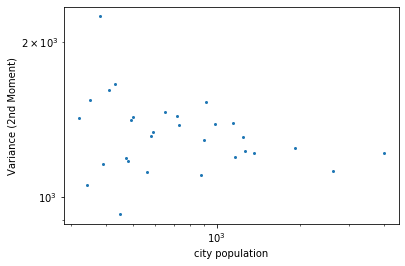

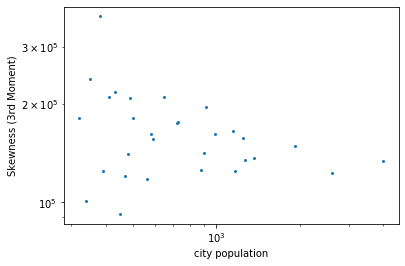

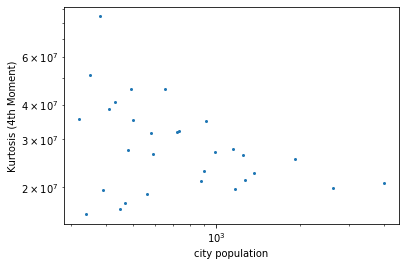

model: growth IPDO on Eli's SW


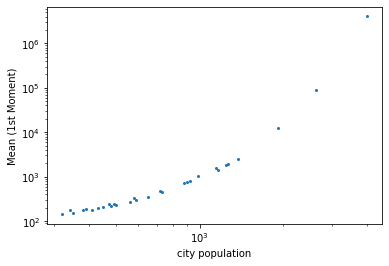

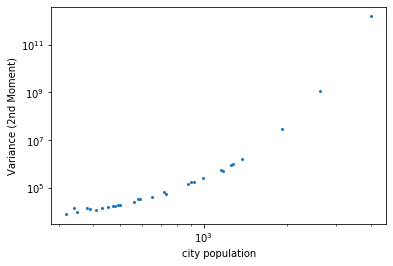

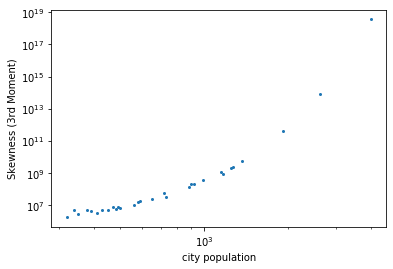

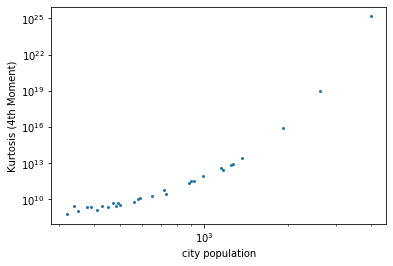

model: growth IPDO on Random Network


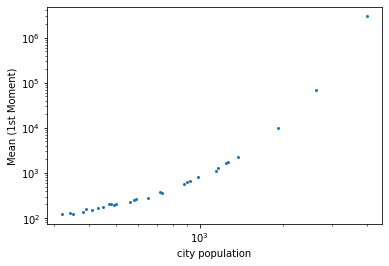

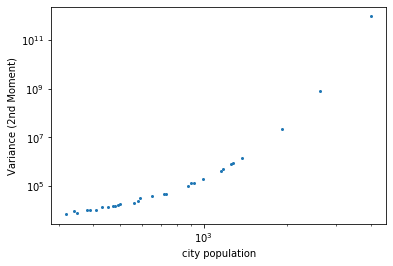

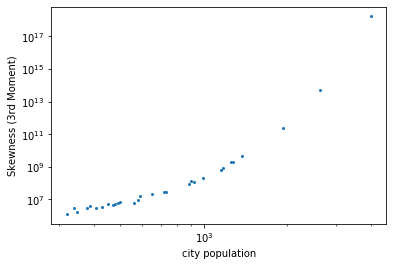

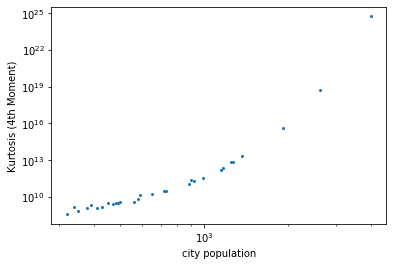

model: Standard IPDO on portugal SW


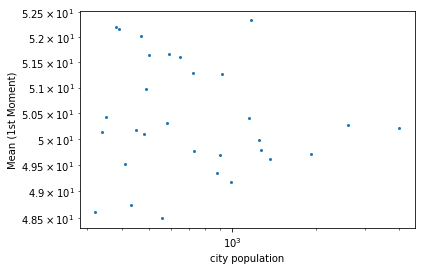

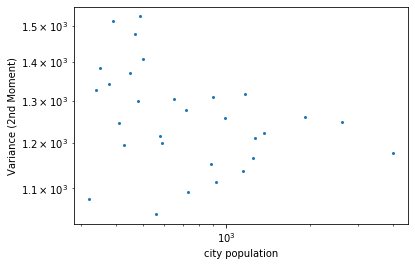

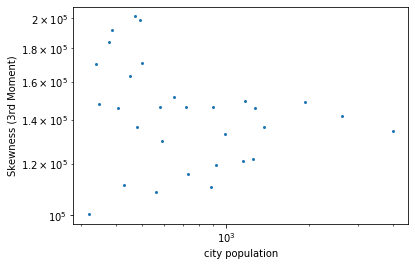

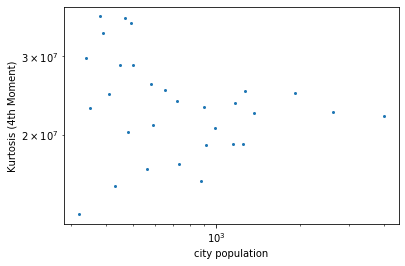

model: Standard IPDO on Eli's SW


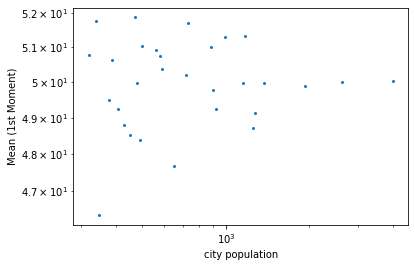

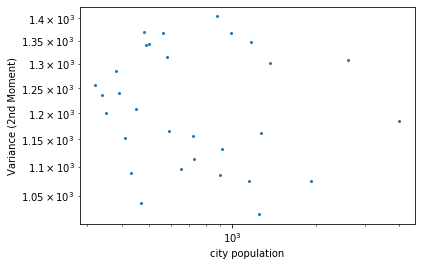

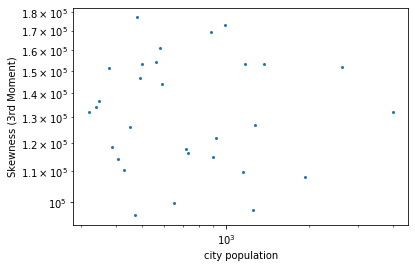

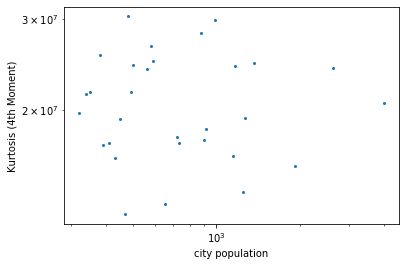

model: growth IPDO on portugal SW


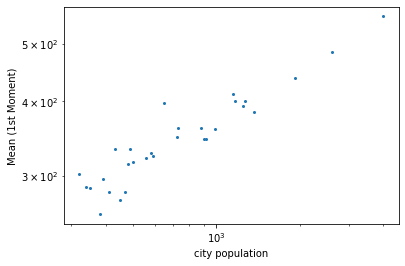

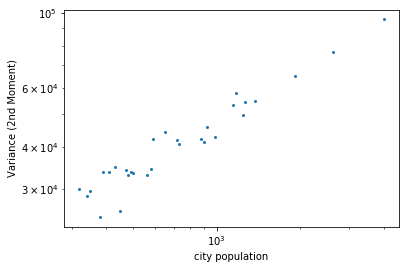

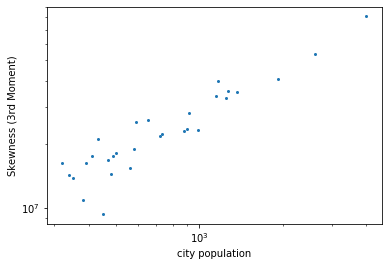

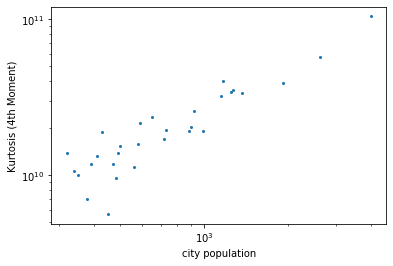

model: Vicky's Update Function on a random network


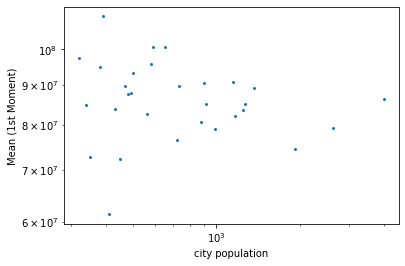

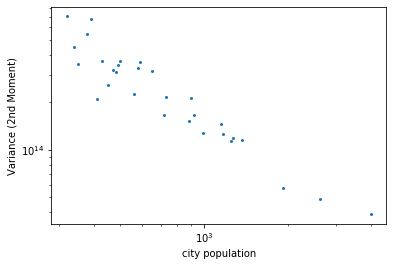

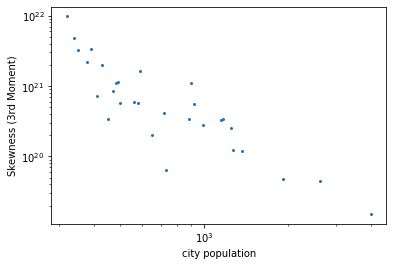

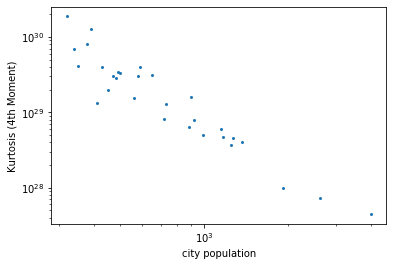

model: Vicky's Update Function on portugal SW


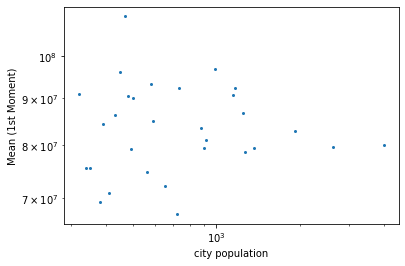

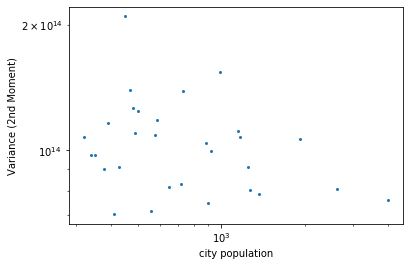

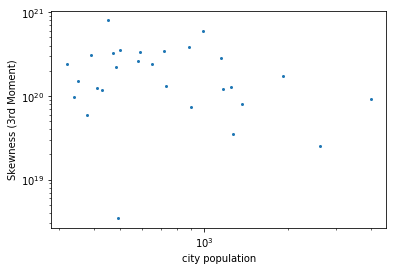

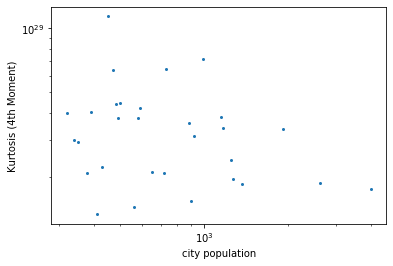

model: Vicky's Update Function on Eli's SW


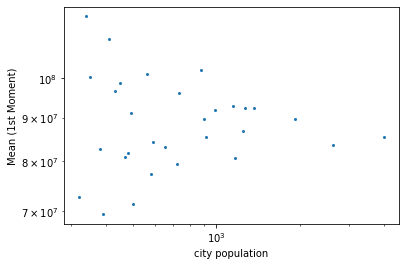

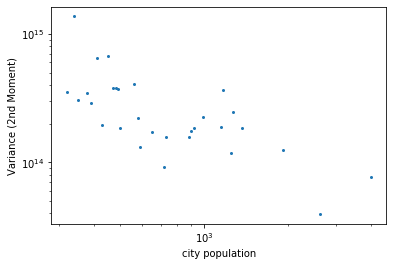

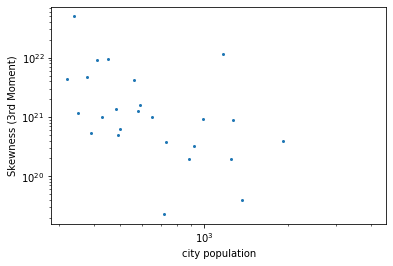

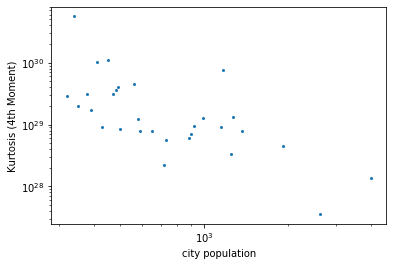

In [32]:
# import scipy.stats
# import seaborn as sns

def calc_moment(dist,m_n):
    avg = np.mean(dist)
    if m_n==1:
        return avg
    n = len(dist)
    diff = dist - avg
    diff_mn = diff**m_n
    m = (1./n)*np.sum(diff_mn)
    return m

# maps moment number n to list of those moments
moments = {}
cpops = {}
for model in models:
    print("model:",model)
    moments[model] = {}
    cpops[model] = []
    for n in range(1,5):
        moments[model][n] = []
    i = 0
    for pop,income in zip(m_pops[model],m_incomes[model]):
        i+= 1
        if i%100 ==0:
            print(i)
        for n in range(1,5):
            manual_m = calc_moment(income,n)
            moments[model][n].append(manual_m)
        cpops[model].append(pop)
    



        
    scale_y = {
          1:1.,
          2:1.,
          3:1.,
          4:1.,
          5:1.
#         1:1.,
#         2:.5,
#         3:.3,
#         4:.3,
#         5:.15
    }

    #TODO: What's going on with the moments that evaluate to zero???

    for n in range(1,5):
        plt.figure()
        plt.xlabel("city population")
        lbl = "nth moment, n = " + str(n) 
        if n == 2:
            lbl = "Variance (2nd Moment)"
        elif n == 1:
            lbl = "Mean (1st Moment)"
        elif n == 3:
            lbl = "Skewness (3rd Moment)"
        elif n == 4:
            lbl = "Kurtosis (4th Moment)"
        plt.ylabel(lbl)
        # TODO: fit regressions in log-linear space, calculate R^2 & p-value
        plt.plot(cpops[model],moments[model][n],'o',markersize=2)
        bottom,top = plt.ylim()
#         plt.ylim((bottom,scale_y[n]*top))
        plt.yscale("log")
        plt.xscale("log")
        plt.show()
        plt.close()
        
        
        
        logpop = np.log(cpops[model])
        logmoments = np.log(moments[model][n])
        #TODO: Test this; it should adjust the scale of higher order moments
#         logmoments = np.log(moments[model][n])/float(n)
        


## Empirical

### First, calculate kde pdfs

In [5]:
kde_pdfs = {}

def wide_silverman(kde_inst):
    n = kde_inst.n
    d = kde_inst.d
    silverman = (n * (d + 2) / 4.)**(-1. / (d + 4))
    scale = 2.
    return silverman*scale



for income_list,pop,cpop in zip(e_incomes,e_ctpops,e_pops):
    income_list = np.array(income_list)
    pop = np.array(pop)/sum(pop)    
    kernel = scipy.stats.gaussian_kde(income_list,weights=pop)#,bw_method=wide_silverman)
    kde_pdfs[cpop] = kernel.pdf


NameError: name 'e_incomes' is not defined

## calculate moments using pdfs generated by kde for each city
Uses scipy.stats.rv_continuous.moment
NOTE: Moments change significantly from raw data to kde-generated pdf. We assume that these changes are representative of the true distributions


    FIXME: Some moments are being returned as zero

In [32]:
# TODO: Stop using KDE pdfs?
class custom_distribution(scipy.stats.rv_continuous):
    def _pdf(self, x, msa):
        #print("in pdf,x = ",x,"msa=",msa)
        #print("in pdf",x)
        ret = kde_pdfs[msa[0]](x[0])
        #print(ret)
        #print("ret=",ret)
        return ret

distribution = custom_distribution(momtype=0)

# maps moment number n to list of those moments
moments = {}
cpops = []

for pop in kde_pdfs: 
#     for i in range(100):
#         print(i)
#         sample = distribution.rvs(msa)
#         samples.append(sample)
        
#     break

    #print("sample:",sample)
    for n in range(1,6):
        if n not in moments:
            moments[n] = []
        moments[n].append(distribution.moment(n,pop))
    cpops.append(pop)
        
#     other_std = np.std(income_lists[msa])
#     #print(std,other_std)
#     stds.append(std)
#     raw_stds.append(other_std)
#     #means.append(distribution.moment(1,msa))


NameError: name 'kde_pdfs' is not defined

### Analyze distribution moments vs. city size

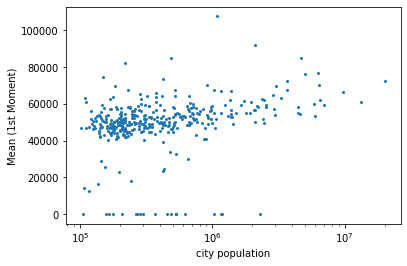

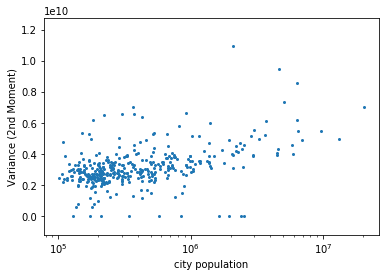

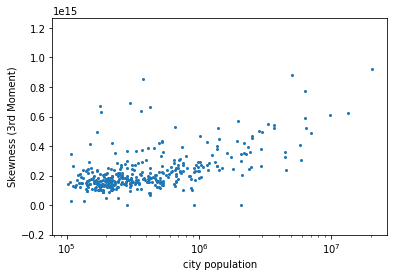

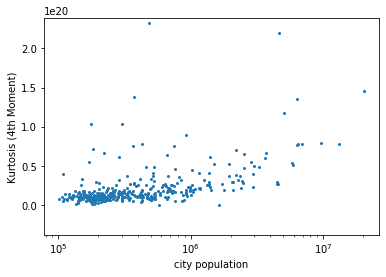

In [19]:
# moment_p = moments
# cpops_p = cpops

scale_y = {
    1:1.,
    2:.5,
    3:.3,
    4:.3,
    5:.15
}

#TODO: What's going on with the moments that evaluate to zero???

for n in range(1,5):
    plt.figure()
    plt.xlabel("city population")
    lbl = "nth moment, n = " + str(n) 
    if n == 2:
        lbl = "Variance (2nd Moment)"
    elif n == 1:
        lbl = "Mean (1st Moment)"
    elif n == 3:
        lbl = "Skewness (3rd Moment)"
    elif n == 4:
        lbl = "Kurtosis (4th Moment)"
    plt.ylabel(lbl)
    # TODO: fit regressions in log-linear space, calculate R^2 & p-value
    plt.plot(cpops,moments[n],'o',markersize=2)
    bottom,top = plt.ylim()
    plt.ylim((bottom,scale_y[n]*top))
    #plt.yscale("log")
    plt.xscale("log")
    plt.show()
    plt.close()
#plt.hist(samples)


# Decile Scaling

## Empirical

In [92]:
plt.rc('xtick', labelsize=12)     
plt.rc('ytick', labelsize=12)
# font = {'family' : 'normal',
#         #'weight' : 'bold',
#         'size'   : 16}
# plt.rc('font', **font)
plt.rcParams.update({'font.size': 16})


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

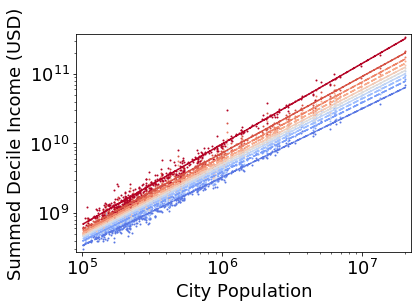

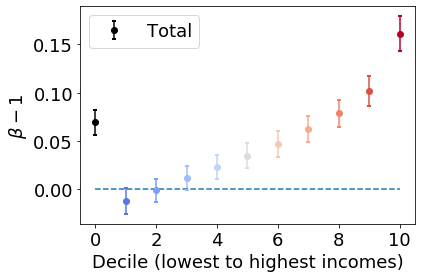

CI for beta vs. decile: [0.12402585478811046,0.2080299923031646]


In [12]:
# maps int (1-10) to pair (list of income_pp,list of city size)
deciles = {}
for i in range(1,11):
    deciles[i] = ([],[])

# empirical case:
full_incs = []
for e_income,e_pop,e_ctpop in zip(e_incomes,e_pops,e_ctpops):

        #split into deciles
        sum_pop = sum(e_ctpop)
        pop_cutoffs = [sum_pop*float(i)/10. for i in range(1,11)]
        cumulative_pop = 0.
        current_decile = 1
        # summed population and income for current decile
        decile_pop = 0.
        decile_inc = 0.
        # sort by income
        e_income,e_ctpop = (list(t) for t in zip(*sorted(zip(e_income, e_ctpop))))
        for ctpop, ctinc in zip(e_ctpop,e_income):
            cumulative_pop += ctpop
            decile_pop += ctpop
            decile_inc += ctinc*ctpop
            if cumulative_pop >= pop_cutoffs[(current_decile - 1)]:
    #             if cumulative_pop == pop_cutoffs[9]:
    #                 print("finish reached")
                current_decile += 1
                #store in deciles
                correction = (sum_pop/10.)/(decile_pop)
                decile_inc *= correction 
                #print(correction)
                #print("Decile:",decile_pop,"full/10:",(sum_pop/10.),"with correction",decile_pop*correction)
                
                deciles[(current_decile-1)][0].append(decile_inc)
#                 deciles[(current_decile-1)][0].append(10*decile_inc/sum_pop)
                deciles[(current_decile-1)][1].append(e_pop)
                #reset
                decile_pop = 0
                decile_inc = 0

        sum_inc = np.sum(np.array(e_income)*np.array(e_ctpop))
        full_incs.append(sum_inc)

        
def standardModelFunc(x,y0,delta):
    return y0*(x**(1+delta))
def standardLogResidual(params, x, true_data):
    model = standardModelFunc(x,params['y0'],params['delta'])
    return np.log(true_data)-np.log(model)
        
def standardLogMod(x,logy0,delta):
    return logy0+x*(1+delta)


def linear(x,b,m):
    return m*x + b

plt.figure()
ax = plt.gca()
decileFits = {}
decileModels = {}
decileParams = {}
betas = []
beta_errors = []
beta_ll = []
beta_ul = []
mods = {}
results = {}
ds = []


cmap = plt.cm.get_cmap('coolwarm')
for i in range(0,11):
    if i > 0:
        x = list(deciles[i][1])
        y = list(deciles[i][0])
        plt.scatter(x,y,s=1,c=cmap(i/10.))
        logx = np.log(x)
        logy = np.log(y)
    else:
        y,x = full_incs,e_pops
        logx = np.log(x)
        logy = np.log(y)


    mods[i] = lmfit.Model(standardLogMod)
    params = mods[i].make_params(logy0=10**4,delta=0)
    #TODO: Should I fit this in linear space?
    results[i] = mods[i].fit(logy,params,x=logx)
    results[i].conf_interval()
    beta_ll.append(-1*(results[i].ci_out['delta'][1][1] - results[i].ci_out['delta'][3][1]))
    beta_ul.append(results[i].ci_out['delta'][5][1] - results[i].ci_out['delta'][3][1])
    ds.append(i)
    betas.append(results[i].ci_out['delta'][3][1])
    fity = np.exp(np.array(results[i].ci_out['logy0'][3][1],dtype=np.float128))*x**(1+results[i].ci_out['delta'][3][1])
    ax.set_yscale("log")
    ax.set_xscale("log")

    coeff, var = curve_fit(standardLogMod, logx, logy)
#     lbl = "decile "+str(i)+", Beta = "+str(round((1.+coeff[1]),3))
    if i > 0:
        ax.plot(x, fity,'--',markersize=1,c=cmap(i/10.))

    
    
#     x= list(deciles[i][1])
#     y = list(deciles[i][0])
#     #print("decile:",i,"x,y = ",x,y)
#     plt.scatter(x,y,s=2)
#     decileParams[i] = lmfit.Parameters()
#     decileParams[i].add_many(('y0',8*list(y)[0]/list(x)[0],True,0,1),('delta',0.,True))
    

#     decileModels[i] = lmfit.Model(standardModelFunc)
#     decileFits[i] = lmfit.minimize(standardLogResidual, decileParams[i], args=(x, y))
#     decileParams[i] = decileFits[i].params
    
#     #using curve_fit
#     logx = np.log(x)
#     logy = np.log(y)
    
    
    
    
#     mods[i] = lmfit.Model(standardLogMod)
#     params = mods[i].make_params(logy0=np.log(10**4),delta=0)
#     #TODO: Should I fit this in linear space?
#     results[i] = mods[i].fit(logy,params,x=logx)
#     results[i].conf_interval()
# #     print(result.fit_report())
# #     print(results[i].ci_report())
# #     print(result.ci_out)
# #     set_trace()
# #     beta_val = result.ci_out['delta'][3][1]
# #     beta_ci = (result.ci_out['delta'][1][1],result.ci_out['delta'][5][1])
#     beta_ll.append(-1*(results[i].ci_out['delta'][1][1] - results[i].ci_out['delta'][3][1]))
#     beta_ul.append(results[i].ci_out['delta'][5][1] - results[i].ci_out['delta'][3][1])
# #     print(beta_ll,beta_ul)
#     betas.append(results[i].ci_out['delta'][3][1])
# #     beta_errors.append(beta_ci)    
    
    
#     coeff, var = curve_fit(standardLogMod, logx, logy)
    
#     # One standard deviation of error of fits
#     err = np.sqrt(np.diag(var))
# #     print(err)
#     lbl = "decile "+str(i)+", Beta = "+str(round((1.+coeff[1]),3))
# #     print(coeff)
#     fity = np.exp(np.array(coeff[0],dtype=np.float128))*x**(1+coeff[1])
# #     betas.append(coeff[1])
# #     beta_errors.append(err[1])
# #     beta_errors.append(((coeff[1]-err[1]),(coeff[1]-err[1])))
#     #print(x,fity)
#     ax.plot(x, fity,'--',label=lbl,markersize=1)
#     #ax.plot(x,decileModels[i].eval(decileParams[i],x=x),'--',label=lbl)
    

plt.xlim((0.9*np.min(deciles[10][1]), 1.1*np.max(deciles[10][1])))
plt.ylim((0.9*np.min(deciles[1][0]), 1.1*np.max(deciles[10][0])))
plt.xlabel("City Population")
# plt.ylabel("Per-Person Income (USD)")
plt.ylabel("Summed Decile Income (USD)")


# plt.legend()
plt.show()
plt.close()

def standardLogMod(x,logy0,delta):
    return logy0+x*(1+delta)

plt.plot(list(range(0,11)),np.zeros(len(betas)),'--')
for i in range(0,11):
    c = cmap(i/10.)
    if i == 0:
        plt.errorbar(0,betas[i],yerr=[[beta_ll[i]],[beta_ul[i]]],label="Total",c='black',fmt='o', ecolor='black', capthick=2,capsize=2)
    else:
        plt.errorbar(ds[i],betas[i],yerr=[[beta_ll[i]],[beta_ul[i]]],c=c,fmt='o', ecolor=c, capthick=2,capsize=2)
plt.xlabel("Decile (lowest to highest incomes)")
plt.ylabel("$\\beta - 1$")
plt.legend()
plt.show()
plt.close()
    

def linear(x,m,b):
    return m*x + b
mod_bd = lmfit.Model(linear)
params = mod_bd.make_params(m=0,b=0)
results_bd = mod_bd.fit(betas[1:],params,x=[a/10. for a in list(range(1,11))])
results_bd.conf_interval()
print("CI for beta vs. decile: [{},{}]".format(results_bd.ci_out['m'][1][1],results_bd.ci_out['m'][5][1]))
    

## Model

TODO: Compare what exactly???

IPDO on static SW Net
CI for beta vs. decile: [-0.003607111230569633,0.029665376229408742]
Growth IPDO on static SW
CI for beta vs. decile: [0.005478214526747715,0.0193748085680139]
Vicky's Update Function on static SW net
CI for beta vs. decile: [0.014944265313912367,0.028943827458229147]
Standard IPDO on portugal SW
CI for beta vs. decile: [-0.03798182680505843,-0.022211380606631304]
growth IPDO on portugal SW
CI for beta vs. decile: [-0.04679407175545209,-0.01895586091491041]
Vicky's Update Function on portugal SW
CI for beta vs. decile: [-0.026083719511309222,-0.021003936052887032]


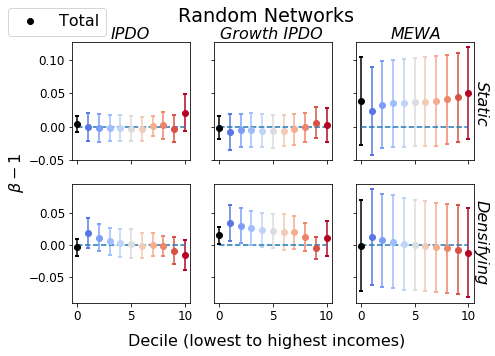

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [108]:
# maps int (1-10) to pair (list of income_pp,list of city size)

size_factor = 0.8
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row',figsize=(9*size_factor,size_factor*6))
i_plot = -1
for model in models:
    i_plot +=1
    deciles = {}
    for i in range(1,11):
        deciles[i] = ([],[])
    print(model)
    results = {}
    full_incs = []
#     fake_ctpops = np.ones((len(m_incomes[model]),len(m_incomes[model][0])))
    for m_income,m_pop in zip(m_incomes[model],m_pops[model]):
        

            m_ctpop = np.ones((len(m_income)))
#             print(m_ctpop)
#             set_trace()
            #split into deciles
            full_inc = 0
            sum_pop = sum(m_ctpop)
            pop_cutoffs = [sum_pop*float(i)/10. for i in range(1,11)]
            cumulative_pop = 0.
            current_decile = 1
            # summed population and income for current decile
            decile_pop = 0.
            decile_inc = 0.
            # sort by income
            m_income,m_ctpop = (list(t) for t in zip(*sorted(zip(m_income, m_ctpop))))
            for ctpop, ctinc in zip(m_ctpop,m_income):
                cumulative_pop += ctpop
                decile_pop += ctpop
                decile_inc += ctinc*ctpop
                full_inc += ctinc*ctpop
                if cumulative_pop >= pop_cutoffs[(current_decile - 1)]:
#                     set_trace()
        #             if cumulative_pop == pop_cutoffs[9]:
        #                 print("finish reached")
                    current_decile += 1
                    #store in deciles
                    correction = (sum_pop/10.)/(decile_pop)
                    decile_inc *= correction 
#                     if abs(1.0-correction) > 0.0001:
#                         print("correction is not equal to 1!")
#                     print("population:", m_pop, "decile:",current_decile,"sum income:",decile_inc)
                    #print(correction)
                    #print("Decile:",decile_pop,"full/10:",(sum_pop/10.),"with correction",decile_pop*correction)

                    deciles[(current_decile-1)][0].append(decile_inc)
                    deciles[(current_decile-1)][1].append(m_pop)
                    #reset
                    decile_pop = 0
                    decile_inc = 0

            sum_inc = np.sum(np.array(m_income)*np.array(m_ctpop))
            full_incs.append(full_inc)
#             print("sum_inc:",sum_inc)
#             print("pop:",m_pop)


    def standardModelFunc(x,y0,delta):
        return y0*(x**(1+delta))
    def standardLogResidual(params, x, true_data):
        model = standardModelFunc(x,params['y0'],params['delta'])
        return np.log(true_data)-np.log(model)

    def standardLogMod(x,logy0,delta):
        return logy0+x*(1+delta)

   
    plt.figure()
    decileFits = {}
    decileModels = {}
    decileParams = {}
    
    mods = {}
    betas = []
    beta_ul = []
    beta_ll = []
    ds = []
    cmap = plt.cm.get_cmap('coolwarm')
    for i in range(0,11):
#         print(i)
        if i > 0:
            x = list(deciles[i][1])
            y = list(deciles[i][0])
#             plt.scatter(x,y,s=2,c=cmap(i/10.))
            logx = np.log(x)
            logy = np.log(y)
        else:
            y,x = full_incs,m_pops[model]
            x = [a for a in x]
            logx = np.log(x)
            logy = np.log(y)
        
        
        mods[i] = lmfit.Model(standardLogMod)
        params = mods[i].make_params(logy0=10,delta=0)
        #TODO: Should I fit this in linear space?
        results[i] = mods[i].fit(logy,params,x=logx)
        results[i].conf_interval()
        beta_ll.append(-1*(results[i].ci_out['delta'][1][1] - results[i].ci_out['delta'][3][1]))
        beta_ul.append(results[i].ci_out['delta'][5][1] - results[i].ci_out['delta'][3][1])
        ds.append(i)
        betas.append(results[i].ci_out['delta'][3][1])
        fity = np.exp(np.array(results[i].ci_out['logy0'][3][1],dtype=np.float128))*x**(1+results[i].ci_out['delta'][3][1])
    
# #         lbl = "decile "+str(i)+", Beta = "+str(round((1.+coeff[1]),3))
#         if i > 0:
#             plt.plot(x, fity,'--',markersize=1,c=cmap(i/10.))


#     plt.yscale("log")
#     plt.xscale("log")
#     plt.legend()
#     plt.show()
# #     plt.cla()
#     plt.clf()
    
    
    # FOR SWITCHING X AND Y IN BETA PLOT
#     plt.plot(np.zeros(len(betas)),ds,'--')
#     for i in range(0,10):
#         c = cmap((i+1)/10.)
#         plt.errorbar(betas[i],ds[i],xerr=[[beta_ll[i]],[beta_ul[i]]],c=c,fmt='o', ecolor=c, capthick=2,capsize=2)
#     plt.ylabel("Decile (lowest to highest incomes)")
#     plt.xlabel("$\\beta - 1$")
    
    x = i_plot%3
    y = i_plot//3
    
    ax[y,x].plot(ds,np.zeros(len(betas)),'--')
    for i in range(0,11):
        c = cmap(i/10.)
        if i == 0:
            if i_plot == 0:
                t_plot = ax[y,x].errorbar(0,betas[i],yerr=[[beta_ll[i]],[beta_ul[i]]],label="Total",c='black',fmt='o', ecolor='black', capthick=2,capsize=2)[0]
            else:
                ax[y,x].errorbar(0,betas[i],yerr=[[beta_ll[i]],[beta_ul[i]]],label="Total",c='black',fmt='o', ecolor='black', capthick=2,capsize=2)
        else:
            ax[y,x].errorbar(ds[i],betas[i],yerr=[[beta_ll[i]],[beta_ul[i]]],c=c,fmt='o', ecolor=c, capthick=2,capsize=2)
    
    
    
    def linear(x,m,b):
        return m*x + b
    mod_bd = lmfit.Model(linear)
    params = mod_bd.make_params(m=0,b=0)
    results_bd = mod_bd.fit(betas[1:],params,x=[a/10. for a in ds[1:]])
    results_bd.conf_interval()
    print("CI for beta vs. decile: [{},{}]".format(results_bd.ci_out['m'][1][1],results_bd.ci_out['m'][5][1]))
    
fig.text(0.5, 0.00, 'Decile (lowest to highest incomes)', ha='center')
fig.text(0.00, 0.5, '$\\beta - 1$', va='center', rotation='vertical')

# outer model labels
fig.text(.2, 0.9, 'IPDO', va='center',style='italic')
fig.text(.41, .9, 'Growth IPDO', va='center',style='italic')
fig.text(.74, 0.9, 'MEWA', va='center',style='italic')
fig.text(.9, 0.3, 'Densifying', va='center', rotation=-90,style='italic')
fig.text(.9, 0.7, 'Static', va='center', rotation=-90,style='italic')


# inner model labels
# fig.text(.35, 0.7, 'Static', va='center', rotation=-90,style='italic')
# fig.text(.625, 0.7, 'Static', va='center', rotation=-90,style='italic')
# fig.text(.35, 0.3, 'Densifying', va='center', rotation=-90,style='italic')
# fig.text(.625, 0.3, 'Densifying', va='center', rotation=-90,style='italic')

# h_in_kem = 0.49
# fig.text(.2, h_in_kem, 'IPDO', va='center',style='italic')
# fig.text(.41, h_in_kem, 'Growth IPDO', va='center',style='italic')
# fig.text(.74, h_in_kem, 'MEWA', va='center',style='italic')

# plt.xlabel("Decile (lowest to highest incomes)")
# plt.ylabel("$\\beta - 1$")
fig.suptitle("Random Networks")
fig.legend([t_plot],["Total"],loc='upper left')#,bbox_to_anchor=(1., 1.))
plt.show()
# plt.close()

[5143.751378666259, 24685.94262902863, 50733.77662110774, 98610.14195760473, 198736.29433335946, 502115.0883107309]


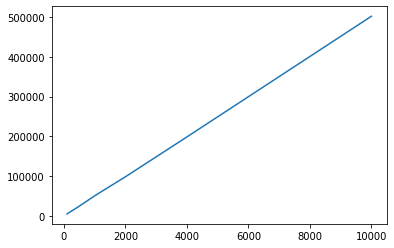

In [12]:
# m_incomes["A"] = np.array(m_incomes["A"])
# print(m_incomes["A"])
sum_incs = list(map(lambda x: np.sum(x),m_incomes["A"]))
print(sum_incs)
plt.plot(m_pops["A"],sum_incs)